# Spaceship Titanic

Welcome to the year 2912, where your data science skills are needed to solve a cosmic mystery. We've received a transmission from four lightyears away and things aren't looking good.

The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.

While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!

To help rescue crews and retrieve the lost passengers, we are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.

Let's start with the importing needed libraries that we'll use later:

In [5]:
import numpy as np
import pandas as pd

from catboost import CatBoostClassifier

import ydf

from keras_tuner import Hyperband
from keras.models import Sequential, load_model
from keras.layers import Input, Dense, BatchNormalization, Activation, Dropout
from keras.initializers import HeNormal
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical, plot_model

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix
from joblib import dump, load
import shap

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

## Data loading

Firstly, we have to load datasets providing in the competition. Read the `train` dataframe:

In [6]:
df_train = pd.read_csv('/content/drive/MyDrive/kaggle/spaceship_titanic/data/train.csv')

In [7]:
df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


And read the `test` dataframe:

In [9]:
df_test = pd.read_csv('/content/drive/MyDrive/kaggle/spaceship_titanic/data/test.csv')

In [10]:
df_test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [11]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


Also read the `sample_submission` dataframe:

In [12]:
df_sample_submission = pd.read_csv('/content/drive/MyDrive/kaggle/spaceship_titanic/data/sample_submission.csv')

In [13]:
df_sample_submission.head()

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False


## EDA

Next, we'll do some explanatory data analysis (EDA) that is really helpful in futher feature engineering. For this purpose, make a copy of `df_train` dataframe:

In [14]:
df_train_eda = df_train.copy()

There are field of the `df_train`:
- `PassengerId` - A unique Id for each passenger. Each Id takes the form `gggg_pp` where `gggg` indicates a group the passenger is travelling with and `pp` is their number within the group. People in a group are often family members, but not always.
- `HomePlanet` - The planet the passenger departed from, typically their planet of permanent residence.
- `CryoSleep` - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- `Cabin` - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
- `Destination` - The planet the passenger will be debarking to.
- `Age` - The age of the passenger.
- `VIP` - Whether the passenger has paid for special VIP service during the voyage.
- `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck` - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- `Name` - The first and last names of the passenger.
- `Transported` - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [15]:
df_train_eda.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


Let's destruct the `PassengerId` into `GroupNumber` and `PeopleNumber` columns and the `Cabin` into `Deck`, `Number` and `Side` columns. Futher, count `Group` sizes and create `TotalBill` series that illustrates all bills in `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa` and `VRDeck`.

In [16]:
def convert_columns(df, columns, convertation_type):
    df[columns] = df[columns].astype(convertation_type)
    return df

In [17]:
# `PassengerId` and `Cabin` destruction
df_train_eda[['GroupNumber', 'PeopleNumber']] = df_train_eda['PassengerId'].str.split('_', expand=True)
df_train_eda[['Deck', 'Number', 'Side']] = df_train_eda['Cabin'].str.split('/', expand=True)
# Counting of the groups sizes
df_train_eda['GroupSize'] = df_train_eda.groupby('GroupNumber')['GroupNumber'] \
                                        .transform('size')
# `TotalBill` formation
df_train_eda['TotalBill'] = df_train_eda[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)
# Some preparation
df_train_eda.drop(columns=['PassengerId', 'Name', 'Cabin'],inplace=True)
df_train_eda = convert_columns(df_train_eda,
                               columns=['GroupNumber', 'PeopleNumber', 'Number'],
                               convertation_type='Int64')

In [18]:
df_train_eda.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,GroupNumber,PeopleNumber,Deck,Number,Side,GroupSize,TotalBill
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,1,1,B,0,P,1,0.0
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,2,1,F,0,S,1,736.0
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,3,1,A,0,S,2,10383.0
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,3,2,A,0,S,2,5176.0
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,4,1,F,1,S,1,1091.0


Take a look at unique values of the `df_train` and `df_test` dataframes to make sure that `df_train` values illustrates common tendecies for both dataframes.

In [19]:
df_train[['Deck', 'Number', 'Side']] = df_train['Cabin'].str.split('/', expand=True)
df_test[['Deck', 'Number', 'Side']] = df_test['Cabin'].str.split('/', expand=True)

print("Unique values at:")
print("1) HomePlanet")
print("       train -", (df_train['HomePlanet']).unique())
print("       test  -", (df_test['HomePlanet']).unique())
print("2) Destination")
print("       train -", (df_train['Destination']).unique())
print("       test  -", (df_test['Destination']).unique())
print("3) Deck")
print("       train -", (df_train['Deck']).unique())
print("       test  -", (df_test['Deck']).unique())
print("4) Side")
print("       train -", (df_train['Side']).unique())
print("       test  -", (df_test['Side']).unique())

Unique values at:
1) HomePlanet
       train - ['Europa' 'Earth' 'Mars' nan]
       test  - ['Earth' 'Europa' 'Mars' nan]
2) Destination
       train - ['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e' nan]
       test  - ['TRAPPIST-1e' '55 Cancri e' 'PSO J318.5-22' nan]
3) Deck
       train - ['B' 'F' 'A' 'G' nan 'E' 'D' 'C' 'T']
       test  - ['G' 'F' 'C' 'B' 'D' 'E' nan 'A' 'T']
4) Side
       train - ['P' 'S' nan]
       test  - ['S' 'P' nan]


Compute all NA values of a dataframe:

In [20]:
def analyze_na(df):
    na_summary = pd.DataFrame({
        'NA count': df.isna().sum(),
        'NA percentage (%)': df.isna().mean()
    })
    return na_summary

In [21]:
analyze_na(df_train_eda)

,NA count,NA percentage (%)
HomePlanet,201,0.023122
CryoSleep,217,0.024963
Destination,182,0.020936
Age,179,0.020591
VIP,203,0.023352
RoomService,181,0.020821
FoodCourt,183,0.021051
ShoppingMall,208,0.023927
Spa,183,0.021051
VRDeck,188,0.021627


Describe counts of `CryoSleep`, `VIP` and `Transported` values:

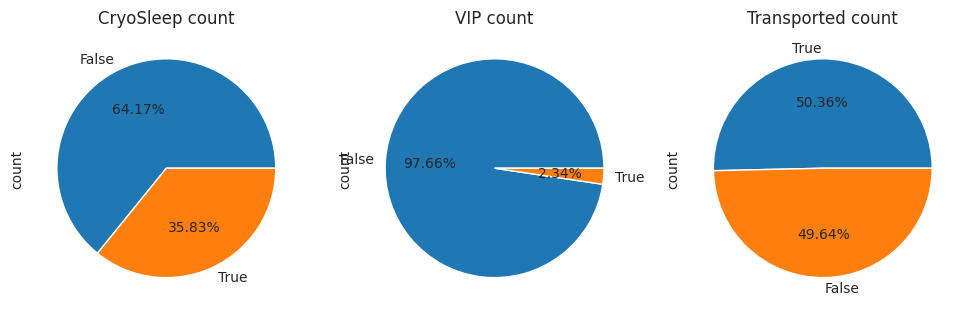

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 12))
columns_to_plot = ['CryoSleep', 'VIP', 'Transported']
for i in range(len(columns_to_plot)):
    df_train_eda[columns_to_plot[i]].value_counts() \
                                    .plot(kind='pie',
                                          title=f'{columns_to_plot[i]} count',
                                          autopct='%1.2f%%',
                                          ax=axes[i])

Analyze a spreading of `VIP` and `Transported` values. It seems like there's no visible correlation between the features.

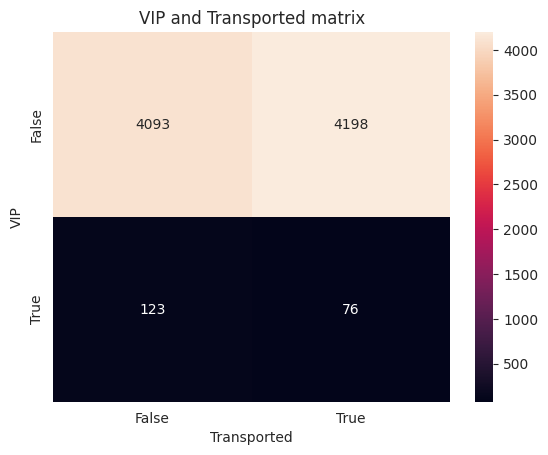

In [23]:
df_train_eda_cleaned = df_train_eda[['VIP', 'Transported']].dropna()
cm = pd.crosstab(df_train_eda_cleaned['VIP'],
                 df_train_eda_cleaned['Transported'],
                 rownames=['VIP'],
                 colnames=['Transported'])

_ = sns.heatmap(cm, annot=True, fmt='d') \
       .set_title('VIP and Transported matrix')

There are the `Age` distribution mapped by `Transported` and `VIP` values. We can see that the transportation almost didn't correlate with a people's age.

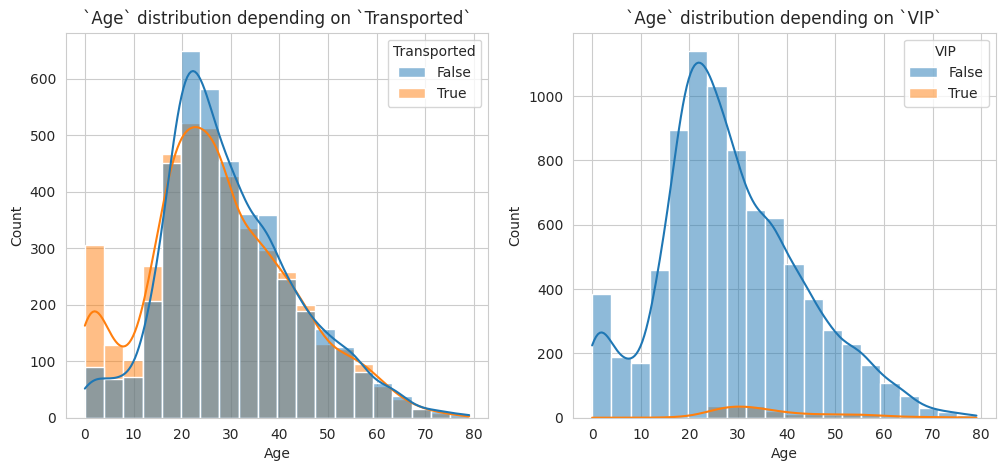

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
_ = sns.histplot(data=df_train_eda, x='Age', hue='Transported',
                 bins=20, kde=True, ax=axes[0]) \
       .set_title('`Age` distribution depending on `Transported`')
_ = sns.histplot(data=df_train_eda, x='Age', hue='VIP',
                 bins=20, kde=True, ax=axes[1]) \
       .set_title('`Age` distribution depending on `VIP`')

Take a look at the `HomePlanet`, `Destination`, `CryoSleep`, `Deck` and `Side` values divided by `Transported` and `VIP`. `CryoSleep` and `Deck` definetly affect on the `Transported`.

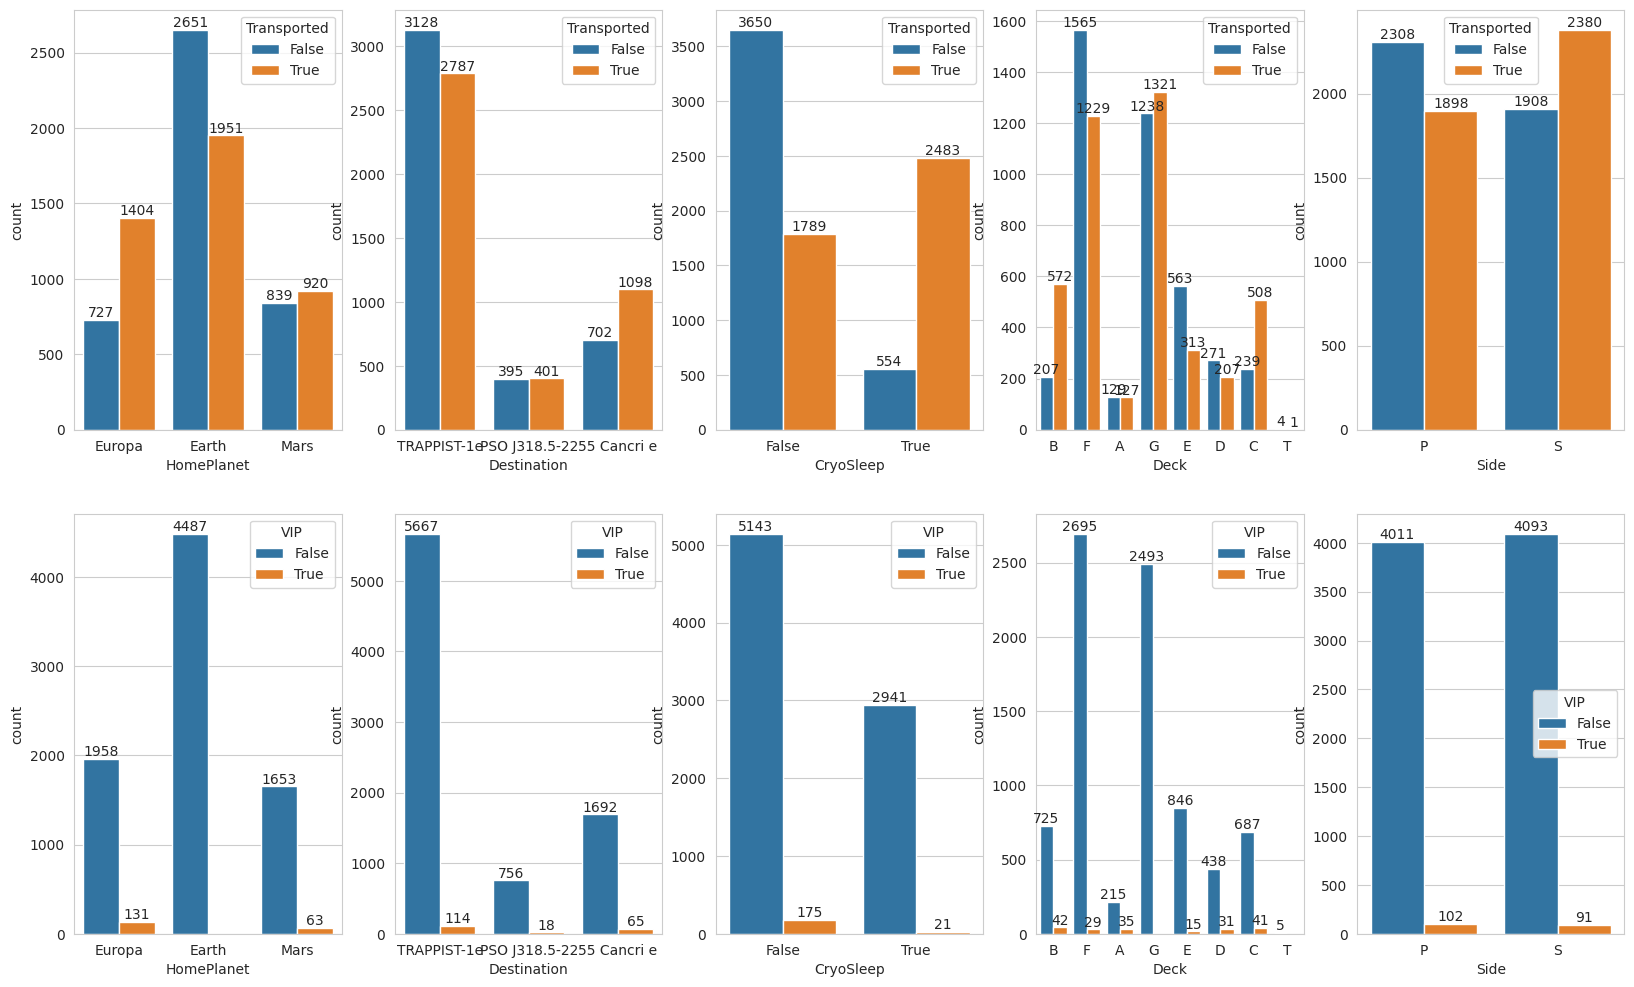

In [25]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 12))
columns_to_plot = ['HomePlanet', 'Destination', 'CryoSleep', 'Deck', 'Side']
columns_to_hue = ['Transported', 'VIP']
for i in range(len(columns_to_plot)):
    for j in range(len(columns_to_hue)):
        ax = sns.countplot(data=df_train_eda, x=columns_to_plot[i], hue=columns_to_hue[j],
                           ax=axes[j][i])
        _ = ax.bar_label(ax.containers[0])
        _ = ax.bar_label(ax.containers[1])

Look at the `TotalBill` value spreading depending on the `Transported` and `VIP` values. I don't think there is a some correlation.

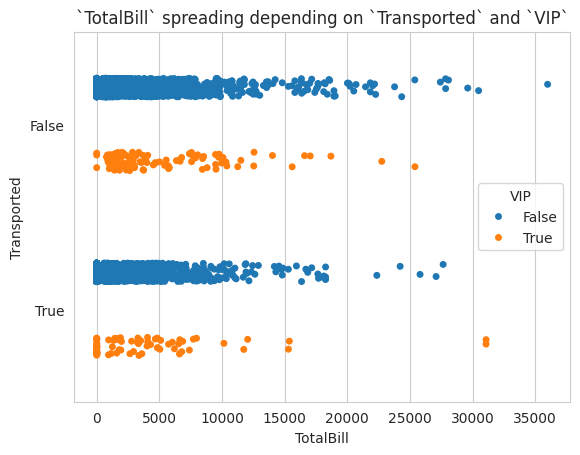

In [26]:
_ = sns.stripplot(data=df_train_eda, x='TotalBill', y='Transported', hue='VIP',
                  dodge=True, orient='h') \
       .set_title('`TotalBill` spreading depending on `Transported` and `VIP`')

Explore a correlation between `Age` and `TotalBill` distributions. We can see that a lot of people was transported with no or a small total bill.

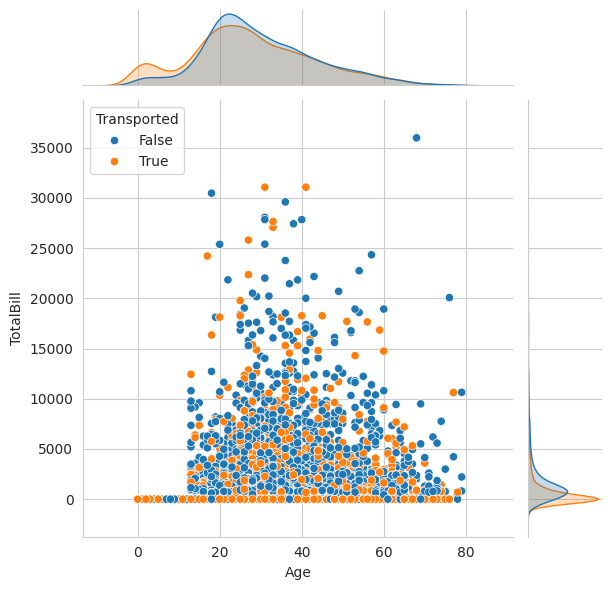

In [27]:
_ = sns.jointplot(data=df_train_eda, x='Age', y='TotalBill', hue='Transported')

Now, check the `Age` distribution on decks depending on `CryoSleep`, `VIP`, `Transported` and `Side`. There's no people in cryo sleep or transported people on the deck `T`, no VIP's on the decks `G` and `T`.  Also, the deck `T` is located at the side `S`.

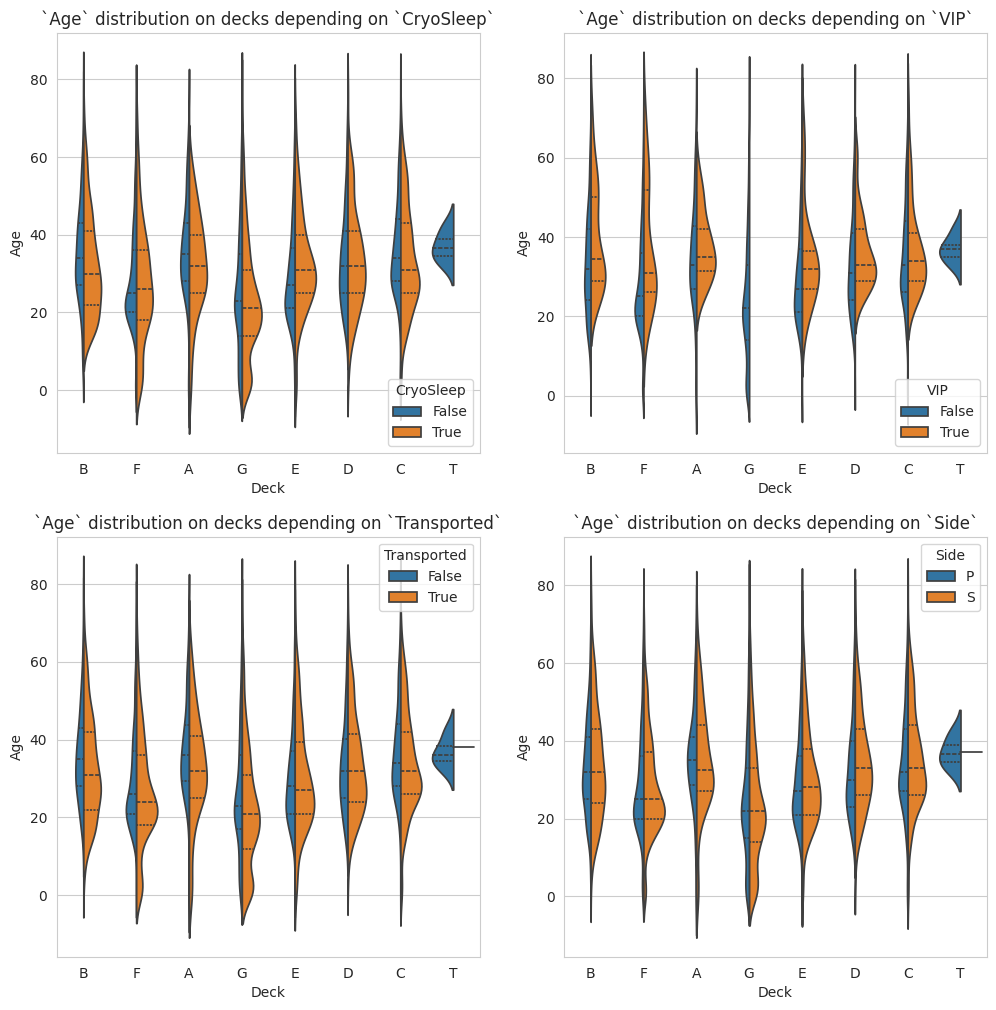

In [28]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
columns_to_hue = ['CryoSleep', 'VIP', 'Transported', 'Side']
for i in range(len(columns_to_hue)):
    sns.violinplot(data=df_train_eda, x='Deck', y='Age',
                   hue=columns_to_hue[i],
                   split=True,
                   inner='quart',
                   ax=axes[i//2][i%2]) \
       .set_title(f"`Age` distribution on decks depending on `{columns_to_hue[i]}`")

Explore `TotalBill` spreading into `Deck`s depending on `Side`. Total bill proportions on the each deck, except `A`, `E` and `C`, look similar.

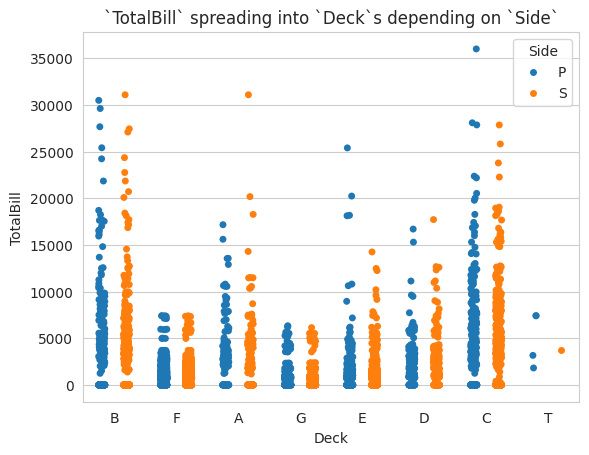

In [29]:
_ = sns.stripplot(data=df_train_eda, x='Deck', y='TotalBill',
                  hue='Side', dodge=True) \
       .set_title('`TotalBill` spreading into `Deck`s depending on `Side`')

Analyze `GroupNumber` values - count all group sizes depending on `Transported`. It's obvious that if people are in a group, there is a more chance to be transported.

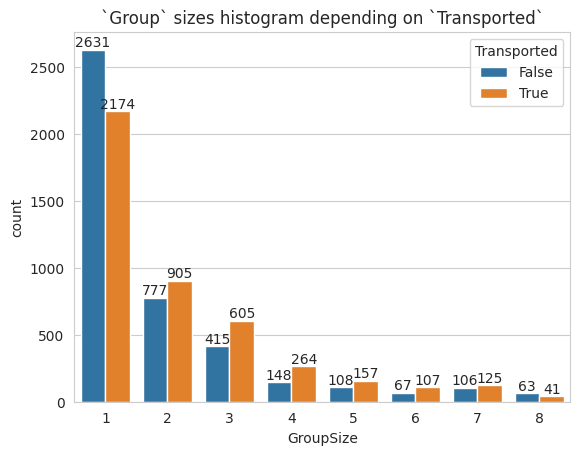

In [30]:
ax = sns.countplot(data=df_train_eda, x='GroupSize', hue='Transported')
_ = ax.bar_label(ax.containers[0])
_ = ax.bar_label(ax.containers[1])
_ = ax.set_title('`Group` sizes histogram depending on `Transported`')

And, finally, let's create a correlation heatmap. For this purpose form the func that encodes the dataframe. There is a high correlation between interesting features: `Transported` and `CryoSleep`, `Number` and `Deck`, `GroupNumber` and `Number`, `Age` and `FoodCourt`, `RoomService` and `HomePlanet`, `TotalBill` and `HomePlanet`.

In [31]:
def make_label_encoder(df):
    cat_col = df.select_dtypes(['object', 'bool']).columns
    transformed_df = pd.DataFrame()
    for col in cat_col:
        le = LabelEncoder()
        transformed_df[col] = le.fit_transform(df[col])
    numeric_col = df.drop(columns=cat_col)
    return pd.concat([transformed_df, numeric_col], axis=1)

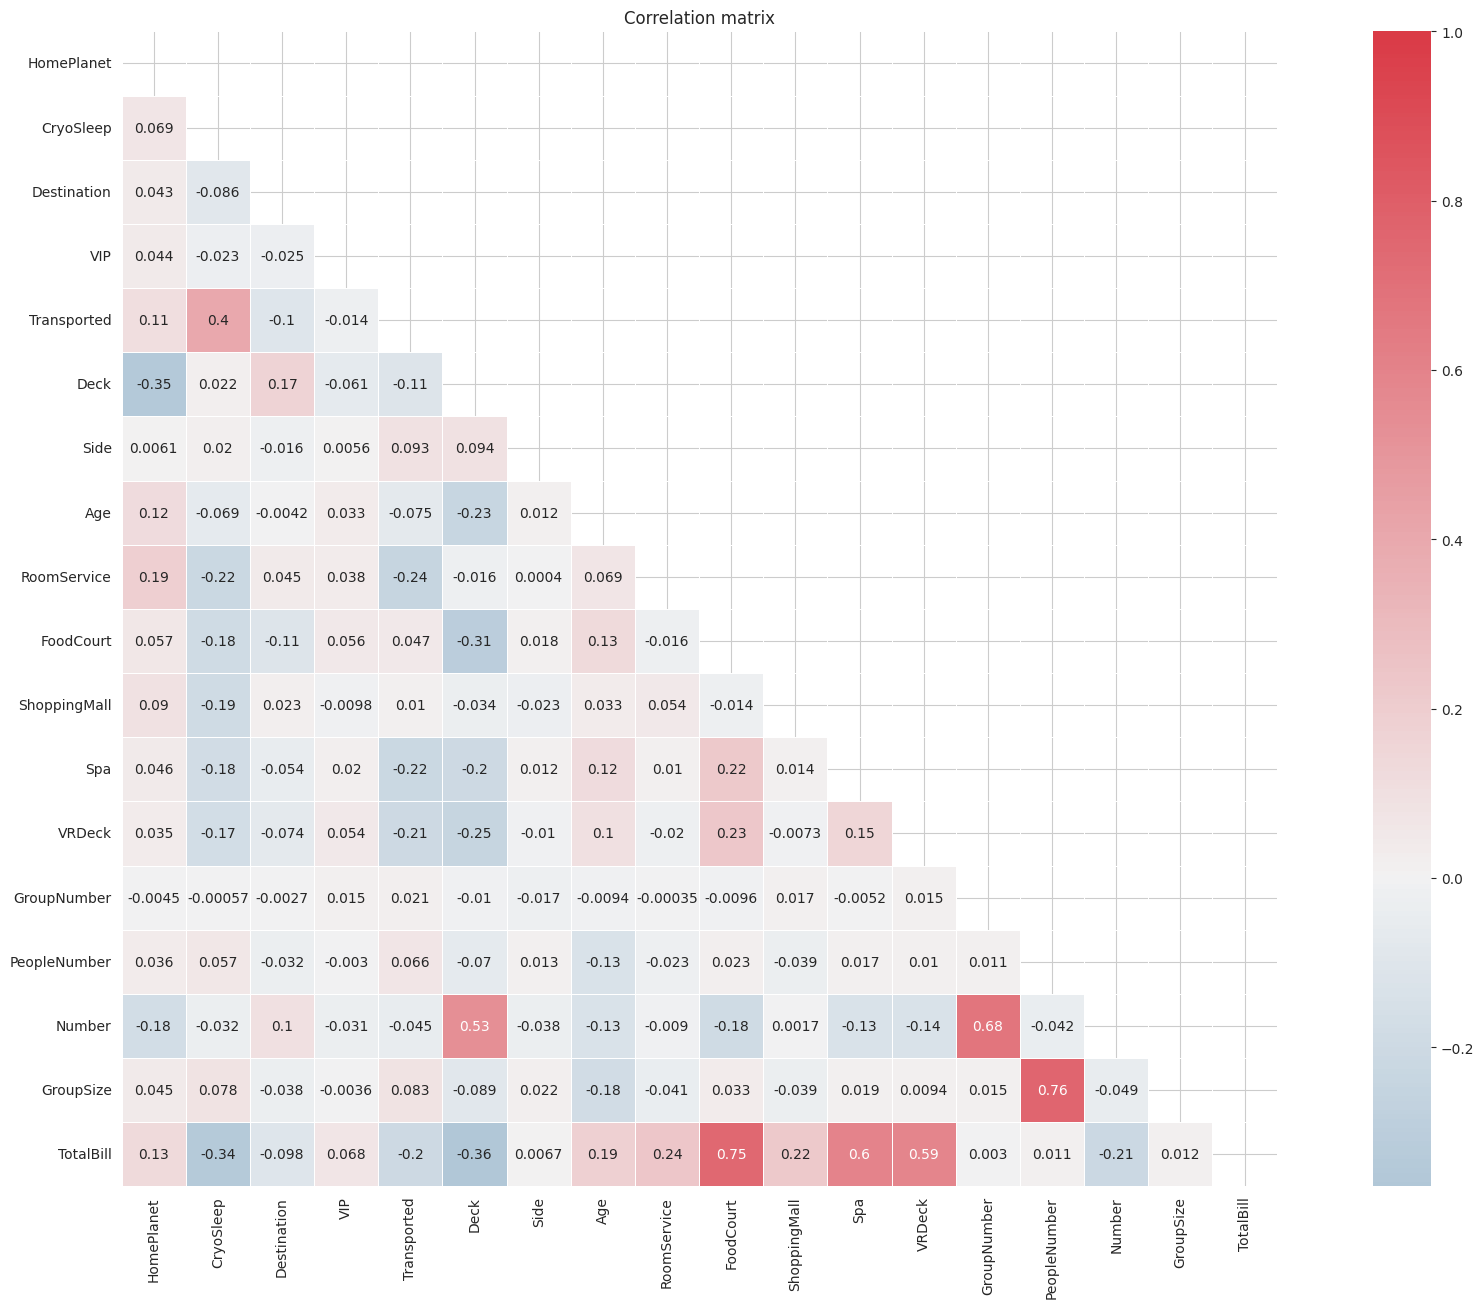

In [32]:
df_train_transformed = make_label_encoder(df_train_eda)
corr = df_train_transformed.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

fig, axes = plt.subplots(figsize=(25, 15))
cmap = sns.diverging_palette(240, 10, as_cmap=True)
_ = sns.heatmap(corr, mask=mask, cmap=cmap,
                vmax=1, center=0, square=True, linewidths=.5, annot=True) \
       .set_title('Correlation matrix')

## Data preparation

For the purpose of `X` and `y` samples preprocessing create dataframe `df_common` that consist of train and test data. But firstly prepare the dataframes:

In [33]:
# Copy the `df_train`
df_train_prep = df_train.copy()
# `PassengerId` and `Cabin` destruction
df_train_prep[['GroupNumber', 'PeopleNumber']] = df_train_prep['PassengerId'].str.split('_', expand=True)
df_train_prep[['Deck', 'Number', 'Side']] = df_train_prep['Cabin'].str.split('/', expand=True)
# Counting of the groups sizes
df_train_prep['GroupSize'] = df_train_prep.groupby('GroupNumber')['GroupNumber'] \
                                          .transform('size')
# `TotalBill` formation
df_train_prep['TotalBill'] = df_train_prep[
    ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
].sum(axis=1)
# Some other preparation
df_train_prep.drop(columns=['PassengerId', 'Name', 'Cabin', 'Transported'], inplace=True)
df_train_prep = convert_columns(df_train_prep,
                                columns=['GroupNumber', 'PeopleNumber', 'Number'],
                                convertation_type='Int64')
# Mark the dataframe
df_train_prep['Type'] = 'train'

# Copy the `df_test`
df_test_prep = df_test.copy()
# `PassengerId` and `Cabin` destruction
df_test_prep[['GroupNumber', 'PeopleNumber']] = df_test_prep['PassengerId'].str.split('_', expand=True)
df_test_prep[['Deck', 'Number', 'Side']] = df_test_prep['Cabin'].str.split('/', expand=True)
# Counting of the groups sizes
df_test_prep['GroupSize'] = df_test_prep.groupby('GroupNumber')['GroupNumber'] \
                                        .transform('size')
# `TotalBill` formation
df_test_prep['TotalBill'] = df_test_prep[
    ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
].sum(axis=1)
# Some other preparation
df_test_prep.drop(columns=['Name', 'Cabin', 'PassengerId'], inplace=True)
df_test_prep = convert_columns(df_test_prep,
                               columns=['GroupNumber', 'PeopleNumber', 'Number'],
                               convertation_type='Int64')
# Mark the dataframe
df_test_prep['Type'] = 'test'

df_common = pd.concat([df_train_prep, df_test_prep], ignore_index=True)

In [34]:
df_common.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    12682 non-null  object 
 1   CryoSleep     12660 non-null  object 
 2   Destination   12696 non-null  object 
 3   Age           12700 non-null  float64
 4   VIP           12674 non-null  object 
 5   RoomService   12707 non-null  float64
 6   FoodCourt     12681 non-null  float64
 7   ShoppingMall  12664 non-null  float64
 8   Spa           12686 non-null  float64
 9   VRDeck        12702 non-null  float64
 10  Deck          12671 non-null  object 
 11  Number        12671 non-null  Int64  
 12  Side          12671 non-null  object 
 13  GroupNumber   12970 non-null  Int64  
 14  PeopleNumber  12970 non-null  Int64  
 15  GroupSize     12970 non-null  int64  
 16  TotalBill     12970 non-null  float64
 17  Type          12970 non-null  object 
dtypes: Int64(3), float64(7), i

Tackle all missing values with the following func:

In [35]:
def imputer_func(col, data, strategy='mean'):
    imp = SimpleImputer(strategy=strategy)
    data[col] = imp.fit_transform(data[[col]]).ravel()
    return data[col]

In [36]:
df_common['HomePlanet'] = imputer_func('HomePlanet', df_common, strategy='most_frequent')
df_common['CryoSleep'] = imputer_func('CryoSleep', df_common, strategy='most_frequent')
df_common['Destination'] = imputer_func('Destination', df_common, strategy='most_frequent')
df_common['Age'] = imputer_func('Age', df_common, strategy='mean')
df_common['VIP'] = imputer_func('VIP', df_common, strategy='most_frequent')
df_common['RoomService'] = imputer_func('RoomService', df_common, strategy='median')
df_common['FoodCourt'] = imputer_func('FoodCourt', df_common, strategy='median')
df_common['ShoppingMall'] = imputer_func('ShoppingMall', df_common, strategy='median')
df_common['Spa'] = imputer_func('Spa', df_common, strategy='median')
df_common['VRDeck'] = imputer_func('VRDeck', df_common, strategy='median')
df_common['Deck'] = imputer_func('Deck', df_common, strategy='most_frequent')
df_common['Number'] = imputer_func('Number', df_common, strategy='most_frequent')
df_common['Side'] = imputer_func('Side', df_common, strategy='most_frequent')

In [37]:
analyze_na(df_common)

,NA count,NA percentage (%)
HomePlanet,0,0.0
CryoSleep,0,0.0
Destination,0,0.0
Age,0,0.0
VIP,0,0.0
RoomService,0,0.0
FoodCourt,0,0.0
ShoppingMall,0,0.0
Spa,0,0.0
VRDeck,0,0.0


Now, we encode string values:

In [38]:
le = LabelEncoder()
columns_to_encode = ['HomePlanet', 'Destination', 'Deck', 'Side', 'Type']
for column in columns_to_encode:
    df_common[column] = le.fit_transform(df_common[column])

In [39]:
df_common.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,Number,Side,GroupNumber,PeopleNumber,GroupSize,TotalBill,Type
0,1,False,2,39.0,False,0.0,0.0,0.0,0.0,0.0,1,0.0,0,1,1,1,0.0,1
1,0,False,2,24.0,False,109.0,9.0,25.0,549.0,44.0,5,0.0,1,2,1,1,736.0,1
2,1,False,2,58.0,True,43.0,3576.0,0.0,6715.0,49.0,0,0.0,1,3,1,2,10383.0,1
3,1,False,2,33.0,False,0.0,1283.0,371.0,3329.0,193.0,0,0.0,1,3,2,2,5176.0,1
4,0,False,2,16.0,False,303.0,70.0,151.0,565.0,2.0,5,1.0,1,4,1,1,1091.0,1


Convert `bool` columns to `int` dtype:

In [40]:
columns_to_convert = ['Age', 'VIP', 'CryoSleep', 'GroupNumber', 'PeopleNumber', 'Number']
df_common[columns_to_convert] = df_common[columns_to_convert].apply(lambda x: x.astype(int))

And scale all the values:

In [41]:
scaler = MinMaxScaler()
df_common[df_common.columns] = scaler.fit_transform(df_common[df_common.columns])

As the result we've got the next dataframe:

In [42]:
df_common.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,Number,Side,GroupNumber,PeopleNumber,GroupSize,TotalBill,Type
0,0.5,0.0,1.0,0.493671,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.0
1,0.0,0.0,1.0,0.303797,0.0,0.007608,0.000302,0.001064,0.024500,0.001823,0.714286,0.000000,1.0,0.000108,0.000000,0.000000,0.020452,1.0
2,0.5,0.0,1.0,0.734177,1.0,0.003001,0.119948,0.000000,0.299670,0.002030,0.000000,0.000000,1.0,0.000216,0.000000,0.142857,0.288521,1.0
3,0.5,0.0,1.0,0.417722,0.0,0.000000,0.043035,0.015793,0.148563,0.007997,0.000000,0.000000,1.0,0.000216,0.142857,0.142857,0.143830,1.0
4,0.0,0.0,1.0,0.202532,0.0,0.021149,0.002348,0.006428,0.025214,0.000083,0.714286,0.000528,1.0,0.000323,0.000000,0.000000,0.030317,1.0


In [43]:
df_common.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    12970 non-null  float64
 1   CryoSleep     12970 non-null  float64
 2   Destination   12970 non-null  float64
 3   Age           12970 non-null  float64
 4   VIP           12970 non-null  float64
 5   RoomService   12970 non-null  float64
 6   FoodCourt     12970 non-null  float64
 7   ShoppingMall  12970 non-null  float64
 8   Spa           12970 non-null  float64
 9   VRDeck        12970 non-null  float64
 10  Deck          12970 non-null  float64
 11  Number        12970 non-null  float64
 12  Side          12970 non-null  float64
 13  GroupNumber   12970 non-null  float64
 14  PeopleNumber  12970 non-null  float64
 15  GroupSize     12970 non-null  float64
 16  TotalBill     12970 non-null  float64
 17  Type          12970 non-null  float64
dtypes: float64(18)
memory usag

In [44]:
df_common.describe()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,Number,Side,GroupNumber,PeopleNumber,GroupSize,TotalBill,Type
count,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000,12970.000000
mean,0.327718,0.353200,0.750732,0.363999,0.021049,0.015242,0.014822,0.007270,0.013465,0.012450,0.619562,0.312343,0.515035,0.499444,0.073070,0.146139,0.039826,0.670239
std,0.399927,0.477983,0.405369,0.180217,0.143552,0.044794,0.052596,0.024866,0.049926,0.048426,0.248839,0.270831,0.499793,0.289461,0.148929,0.225300,0.078011,0.470144
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.500000,0.253165,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.428571,0.082365,0.000000,0.248437,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.341772,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.714286,0.215945,1.000000,0.499084,0.000000,0.000000,0.019896,1.000000
75%,0.500000,1.000000,1.000000,0.468354,0.000000,0.002984,0.002105,0.000979,0.002231,0.001492,0.857143,0.523759,1.000000,0.746174,0.142857,0.142857,0.040070,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Also define the target label:

In [45]:
target = 'Transported'

And, finally, define train and test samples:

In [46]:
X = df_common[df_common['Type'] == 1] \
    .drop(columns=['Type']) \
    .values
y = df_train[target] \
    .astype(int) \
    .values.reshape(-1, 1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)
X_test = df_common[df_common['Type'] == 0] \
    .drop(columns=['Type']) \
    .values

print(f"X sample: [" + ', '.join(format(x, ".2f") for x in X_train[0]) + "]")
print(f"y sample: [" + ', '.join(format(x, ".2f") for x in y_train[0]) + "]")

X sample: [1.00, 0.00, 1.00, 0.34, 0.00, 0.03, 0.00, 0.02, 0.02, 0.00, 0.71, 0.60, 1.00, 0.64, 0.00, 0.29, 0.04]
y sample: [0.00]


In addition, fill na's in the dataframes for futher using in Decision Trees:

In [47]:
# Filling na's
df_train_prep['HomePlanet'] = imputer_func('HomePlanet', df_common, strategy='most_frequent')
df_train_prep['CryoSleep'] = imputer_func('CryoSleep', df_common, strategy='most_frequent')
df_train_prep['Destination'] = imputer_func('Destination', df_common, strategy='most_frequent')
df_train_prep['Age'] = imputer_func('Age', df_common, strategy='mean')
df_train_prep['VIP'] = imputer_func('VIP', df_common, strategy='most_frequent')
df_train_prep['RoomService'] = imputer_func('RoomService', df_common, strategy='median')
df_train_prep['FoodCourt'] = imputer_func('FoodCourt', df_common, strategy='median')
df_train_prep['ShoppingMall'] = imputer_func('ShoppingMall', df_common, strategy='median')
df_train_prep['Spa'] = imputer_func('Spa', df_common, strategy='median')
df_train_prep['VRDeck'] = imputer_func('VRDeck', df_common, strategy='median')
df_train_prep['Deck'] = imputer_func('Deck', df_common, strategy='most_frequent')
df_train_prep['Number'] = imputer_func('Number', df_common, strategy='most_frequent')
df_train_prep['Side'] = imputer_func('Side', df_common, strategy='most_frequent')
# Converting the columns
df_train_prep[columns_to_convert] = df_train_prep[columns_to_convert].apply(lambda x: x.astype(int))
# Splitting the data
df_train_prep.drop(columns=['Type'], inplace=True)
df_train_prep[target] = df_train[target]
df_train_splitted, df_valid_splitted = train_test_split(df_train_prep, test_size=0.25, random_state=42)

# Filling na's
df_test_prep['HomePlanet'] = imputer_func('HomePlanet', df_common, strategy='most_frequent')
df_test_prep['CryoSleep'] = imputer_func('CryoSleep', df_common, strategy='most_frequent')
df_test_prep['Destination'] = imputer_func('Destination', df_common, strategy='most_frequent')
df_test_prep['Age'] = imputer_func('Age', df_common, strategy='mean')
df_test_prep['VIP'] = imputer_func('VIP', df_common, strategy='most_frequent')
df_test_prep['RoomService'] = imputer_func('RoomService', df_common, strategy='median')
df_test_prep['FoodCourt'] = imputer_func('FoodCourt', df_common, strategy='median')
df_test_prep['ShoppingMall'] = imputer_func('ShoppingMall', df_common, strategy='median')
df_test_prep['Spa'] = imputer_func('Spa', df_common, strategy='median')
df_test_prep['VRDeck'] = imputer_func('VRDeck', df_common, strategy='median')
df_test_prep['Deck'] = imputer_func('Deck', df_common, strategy='most_frequent')
df_test_prep['Number'] = imputer_func('Number', df_common, strategy='most_frequent')
df_test_prep['Side'] = imputer_func('Side', df_common, strategy='most_frequent')
# Converting the columns
df_test_prep.drop(columns=['Type'], inplace=True)
df_test_prep[columns_to_convert] = df_test_prep[columns_to_convert].apply(lambda x: x.astype(int))

## Models application

Subsequently, we will apply several forecasting methods in solving the problem, namely Gradient Boosting, Decision Trees, and Multilayer Perceptron. Following this, we will compare the obtained results to determine which model proves to be the most effective.

### 1. Random Forest [YDF]

A **Random Forest** is a collection of deep CART decision trees trained independently and without pruning. Each tree is trained on a random subset of the original training dataset (sampled with replacement). The algorithm is unique in that it is robust to overfitting, even in extreme cases e.g. when there are more features than training examples. It is probably the most well-known of the Decision Forest training algorithms.

Yggdrasil Decision Forests provides advanced optimization techniques and supports various implementations of decision forests, allowing for efficient training and inference. The model exhibits versatility across different domains, handling large datasets and complex relationships effectively, while also enabling interpretability through tree structures.

Let's start with tuning of the `RandomForestLearner` with `RandomSearchTuner`:

In [48]:
is_optimal_rf_found = True

if not is_optimal_rf_found:
    tuner = ydf.RandomSearchTuner(num_trials=500)
    tuner.choice("num_trees", [300, 500, 800, 1000])
    tuner.choice("max_depth", [4, 5, 6, 7, 8, 9])
    tuner.choice("num_candidate_attributes_ratio", [0.8, 0.9, 1.0])
    tuner.choice("min_examples", [5, 10, 15])
    tuner.choice("growing_strategy", ["LOCAL", "BEST_FIRST_GLOBAL"])

    learner = ydf.RandomForestLearner(label=target,
                                      tuner=tuner)
    rf = learner.train(df_train_splitted)
    dump(rf, "/content/drive/MyDrive/kaggle/spaceship_titanic/models/rf.pkl")
else:
    rf = load("/content/drive/MyDrive/kaggle/spaceship_titanic/models/rf.pkl")

There are the model that we've got:

In [49]:
rf.describe()

trial,score,duration,num_trees,max_depth,num_candidate_attributes_ratio,min_examples,growing_strategy
357,0.799049,3376,800,9,0.8,5,LOCAL
383,0.798435,3628.13,1000,9,0.8,5,LOCAL
106,0.798435,1039.41,500,8,0.8,5,LOCAL
197,0.798282,1922.45,500,9,0.8,5,LOCAL
307,0.798282,2900.78,1000,9,1,5,LOCAL
271,0.798282,2564.65,300,8,0.9,5,LOCAL
423,0.798282,3964.74,300,8,1,5,LOCAL
264,0.798282,2510.35,1000,9,0.9,5,LOCAL
126,0.798129,1217.95,300,9,0.8,5,LOCAL
291,0.798129,2722.45,300,8,1,10,LOCAL


Evaluate the `RandomForestLearner` with the validation dataframe:

In [50]:
rf.evaluate(df_valid_splitted)

Label \ Pred,false,true
false,830,187
true,252,905


And make a submission:

In [51]:
predictions = rf.predict(df_test_prep)
predictions_bool = (predictions > 0.5).astype(bool)

output = pd.DataFrame({'PassengerId': df_test['PassengerId'],
                       'Transported': predictions_bool.squeeze()})
output.to_csv('/content/drive/MyDrive/kaggle/spaceship_titanic/submissions/submission_ydf_rf.csv',
              index=False)

### 2. Gradient Boosting [CatBoost]

**CatBoost**, an acronym for "Categorical Boosting," is a gradient boosting algorithm developed by Yandex that optimizes the processing of categorical variables, enhancing the performance of machine learning tasks. It operates on the principle of sequentially building an ensemble of decision trees, where each new tree corrects errors made by its predecessors.

The algorithm begins with an initial prediction and subsequently incorporates new trees, each trained on the residuals of the predictions from the previous ensemble. A unique feature of CatBoost is its ability to handle categorical features directly without extensive preprocessing, such as one-hot encoding. It employs a method called "ordered boosting" which reduces the potential for target leakage by ensuring that each tree is built using only information available prior to prediction.

First of all, tune the `CatBoostClassifier` with the `GridSearchCV`. The method evaluates the performance of a model based on a specified scoring metric, utilizing cross-validation (it is `StratifiedKFold` in this paper) to enhance the reliability of the results. By iteratively assessing combinations of hyperparameters, GridSearchCV identifies the optimal set that maximizes the model's predictive performance.

In [52]:
is_optimal_catboost_found = True

if not is_optimal_catboost_found:
    clf = CatBoostClassifier(verbose=False)
    param_grid = {
        'iterations': [250, 500, 750, 1000],
        'learning_rate': [0.01, 0.05, 0.1],
        'depth': [3, 4, 5, 6, 7],
        'l2_leaf_reg': [1, 3, 5, 7, 8]
    }
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    grid_search = GridSearchCV(clf, param_grid, cv=cv, scoring='accuracy')
    grid_search.fit(X, y)
    clf = grid_search.best_estimator_
    dump(clf, "/content/drive/MyDrive/kaggle/spaceship_titanic/models/cat-boost-Classifier_grid-search_cv.joblib")
    is_optimal_catboost_found = True

    print("Best params of the CatBoost model:")
    print(grid_search.best_estimator_.get_params())
else:
    clf = load("/content/drive/MyDrive/kaggle/spaceship_titanic/models/cat-boost-Classifier_grid-search_cv.joblib")
    print("Best params of the CatBoost model:")
    print(clf.get_params())

Best params of the CatBoost model:
{'verbose': False, 'depth': 6, 'iterations': 250, 'l2_leaf_reg': 5, 'learning_rate': 0.1}


Check the accuracy of the model with defined params by the cross-validation technique:

In [53]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')

print(f'Cross-validation accuracies: {scores}')
print(f'Mean accuracy: {scores.mean()}')

Cross-validation accuracies: [0.82058654 0.81656124 0.81426107 0.82911392 0.80955121]
Mean accuracy: 0.8180147976000386


There are more detailed checking:

Current accuracy: 0.8725850965961361

Classification report:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      1082
           1       0.86      0.89      0.87      1092

    accuracy                           0.87      2174
   macro avg       0.87      0.87      0.87      2174
weighted avg       0.87      0.87      0.87      2174
 

Confusion matrix:


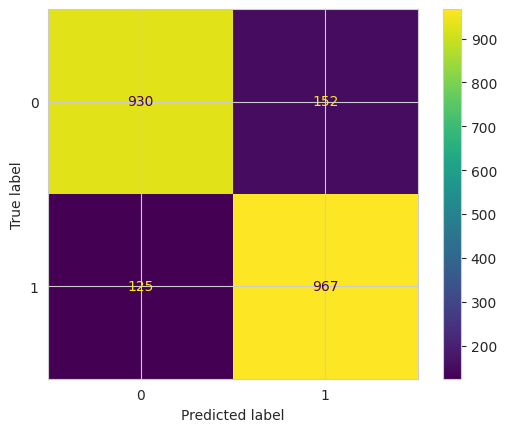

In [54]:
y_pred = clf.predict(X_val)

print(f"Current accuracy: {accuracy_score(y_val, y_pred)}\n")
print("Classification report:")
print(classification_report(y_val, y_pred), "\n")
print("Confusion matrix:")
_ = ConfusionMatrixDisplay.from_estimator(clf, X_val, y_val)

And create a submisstion:

In [55]:
y_test = clf.predict(X_test)
y_test = (y_test > 0.5).astype(bool)

output = pd.DataFrame({'PassengerId': df_test['PassengerId'],
                       'Transported': y_test.squeeze()})
output.to_csv('/content/drive/MyDrive/kaggle/spaceship_titanic/submissions/submission_catboost.csv',
              index=False)

### 3. Multilayer Perceptron [Keras]

**The Multilayer Perceptron** (MLP) is a type of artificial neural network widely implemented in Keras, characterized by its layered architecture. It consists of an input layer, one or more hidden layers, and an output layer. Each layer comprises nodes (neurons) that perform computations based on weighted inputs and activation functions. Data passes from the input layer through the hidden layers, where nonlinear transformations are applied to capture complex patterns. The activation functions, such as ReLU (Rectified Linear Unit) or Sigmoid, introduce non-linearity, allowing the network to learn intricate relationships in the data. The learning process is facilitated by backpropagation, which adjusts the weights of connections through gradient descent optimization algorithms, minimizing the loss function that quantifies prediction errors.

Keras provides a high-level API for constructing MLPs, enabling seamless integration of various activation functions, optimizers, and regularization techniques to enhance model performance and prevent overfitting. This flexibility makes MLPs suitable for a wide range of applications, including classification and regression tasks.

Firstly, tune the MLP model with `Hyperband`. Define constant and variable params:

In [56]:
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]
batch_size = 64
epochs = 100

possible_units = [128, 64, 32, 16, 8, 4]
num_layers = range(2, 6)
kernel_initializers = ['he_normal', 'glorot_uniform', 'lecun_normal']
dropouts = np.arange(0.1, 0.51, 0.05)
optimizers = ['adam', 'rmsprop', 'sgd']

print(f"{'Constant hyperparameter':<25} {'Value':<6} | {'Variable hyperparameter':<25} {'Value':<6}")
print("-" * 100)
print(f"{'input_dim':<25} {input_dim:<6} | {'num_layers':<25} {', '.join(map(str, num_layers)):<25}")
print(f"{'output_dim':<25} {output_dim:<6} | {'possible_units':<25} {', '.join(map(str, possible_units)):<25}")
print(f"{'batch_size':<25} {batch_size:<6} | {'kernel_initializers':<25} {', '.join(kernel_initializers):<25}")
print(f"{'epochs':<25} {epochs:<6} | {'dropouts':<25} {', '.join([f'{value:.2f}' for value in dropouts]):<25}")
print(f"{' ':<32} | {'optimizers':<25} {', '.join(optimizers):<25}")

Constant hyperparameter   Value  | Variable hyperparameter   Value 
----------------------------------------------------------------------------------------------------
input_dim                 17     | num_layers                2, 3, 4, 5               
output_dim                1      | possible_units            128, 64, 32, 16, 8, 4    
batch_size                64     | kernel_initializers       he_normal, glorot_uniform, lecun_normal
epochs                    100    | dropouts                  0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50
                                 | optimizers                adam, rmsprop, sgd       


Next, create a func of the model building that will be used in the tunning process:

In [57]:
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))

    num_layers = hp.Int('hidden_layers',
                        min_value=2,
                        max_value=5,
                        default=2)
    possible_units_shift = hp.Int('possible_units_shift',
                                  min_value=0,
                                  max_value=len(possible_units)-num_layers)

    for i in range(num_layers):
        current_units = possible_units[-(len(possible_units) - possible_units_shift - i)]
        kernel_initializer = hp.Choice('kernel_initializer', kernel_initializers)
        model.add(Dense(hp.Choice(f'units_{i}', [current_units]),
                        kernel_initializer=kernel_initializer))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(rate=hp.Float(f'dropout_{i}', 0.1, 0.5, step=0.05)))

    model.add(Dense(output_dim, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer=hp.Choice('optimizer', optimizers),
                  metrics=['accuracy'])

    return model

So, there is tunning proccess:

In [58]:
is_optimal_mlp_found = True

if not is_optimal_mlp_found:
    tuner = Hyperband(build_model,
                      objective='val_accuracy',
                      max_epochs=epochs,
                      factor=3,
                      directory='/content/drive/MyDrive/kaggle/spaceship_titanic/tuners',
                      project_name='mlp',
                      overwrite=True)
    callback = EarlyStopping(monitor='val_loss',
                             patience=5,
                             restore_best_weights=True)
    tuner.search(X_train, y_train,
                 validation_data=(X_val, y_val),
                 batch_size=batch_size,
                 callbacks=[callback])

    model = tuner.get_best_models()[0]
    model.save('/content/drive/MyDrive/kaggle/spaceship_titanic/models/mlp_hyperband.keras')
    is_optimal_mlp_found = True
else:
    model = load_model('/content/drive/MyDrive/kaggle/spaceship_titanic/models/mlp_hyperband.keras')

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 30 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Check what configuration we've got:

In [59]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           2,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 39,813 (155.52 KB)

 Trainable params: 13,121 (51.25 KB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 26,244 (102.52 KB)

And evaluate it:

In [60]:
results = model.evaluate(X_val, y_val, batch_size=32)
print("test loss, test acc:", results)

68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7935 - loss: 0.4184
test loss, test acc: [0.4023997187614441, 0.8035878539085388]


There are more detailed results:

68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step
Current accuracy: 0.8035878564857406

Classification report:
              precision    recall  f1-score   support

           0       0.80      0.81      0.80      1082
           1       0.81      0.80      0.80      1092

    accuracy                           0.80      2174
   macro avg       0.80      0.80      0.80      2174
weighted avg       0.80      0.80      0.80      2174
 

Confusion matrix:


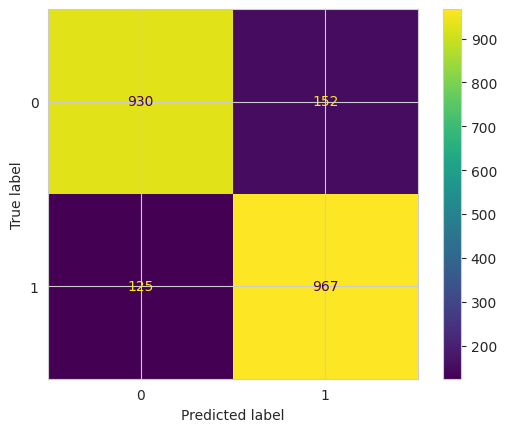

In [62]:
y_pred = model.predict(X_val)
y_pred = (y_pred > 0.5).astype(bool)

print(f"Current accuracy: {accuracy_score(y_val, y_pred)}\n")
print("Classification report:")
print(classification_report(y_val, y_pred), "\n")
print("Confusion matrix:")
_ = ConfusionMatrixDisplay.from_estimator(clf, X_val, y_val)

Finally, create a submission:

In [63]:
y_test = model.predict(X_test)
y_test = (y_test > 0.5).astype(bool)

output = pd.DataFrame({'PassengerId': df_test['PassengerId'],
                       'Transported': y_test.squeeze()})
output.to_csv('/content/drive/MyDrive/kaggle/spaceship_titanic/submissions/submission_mlp.csv',
              index=False)

134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


## Conclusion

While testing our models on validation and test data we have the following results:

| №  | Framework | Model                 | Validation acc | Test acc |
|----|-----------|-----------------------|----------|---|
| 1  | YDF       | RandomForestLearner   | 0.79806 | 0.67266 |
| 2  | CatBoost  | CatBoostClassifier    | **0.87258** | **0.80173** |
| 3  | Keras     | Multilayer Perceptron | 0.80358 | 0.80126 |

Moreover, we can see features importances from each model. For example, the Random Forest provides the analysis of input values dependencies: particial dependecies, conditional expectations and variable importances. It's obvious that `TotalBill` and other bills, `HomePlanet`, `Deck` and `Side` are more important.

In [61]:
rf.analyze(df_valid_splitted)

As a result for the CatBoostClassifier, `TotalBill`, `Deck`, `Number` and `HomePlanet` are the most important:

In [63]:
columns = df_train_prep.drop(columns=['Transported']).columns
importances = clf.get_feature_importance()
print(f"{'Column':<20} {'Importance':<10}")
print("-" * 40)
for i in range(len(columns)):
    print(f"{columns[i]:<20} {importances[i]:<10}")

Column               Importance
----------------------------------------
HomePlanet           9.139938181717465
CryoSleep            4.8063412646053525
Destination          1.685432776966801
Age                  5.278149179888827
VIP                  0.013120887577426304
RoomService          5.004552726790222
FoodCourt            6.821468992334932
ShoppingMall         4.1694731345789044
Spa                  9.150902810960137
VRDeck               7.753810457283889
Deck                 12.881426675613762
Number               9.127732647256195
Side                 4.821629627978632
GroupNumber          4.428015689352236
PeopleNumber         0.5841857599612952
GroupSize            1.0087073093522674
TotalBill            13.325111877781662


In addition, let's analyze a resuls of the MLP work - check importances of the input data features with `shap`. It seems a little bit controversial but intresting - there is a different order of the importances. `CryoSleep` and `Spa` are on the top.

PermutationExplainer explainer: 2175it [19:48,  1.81it/s]


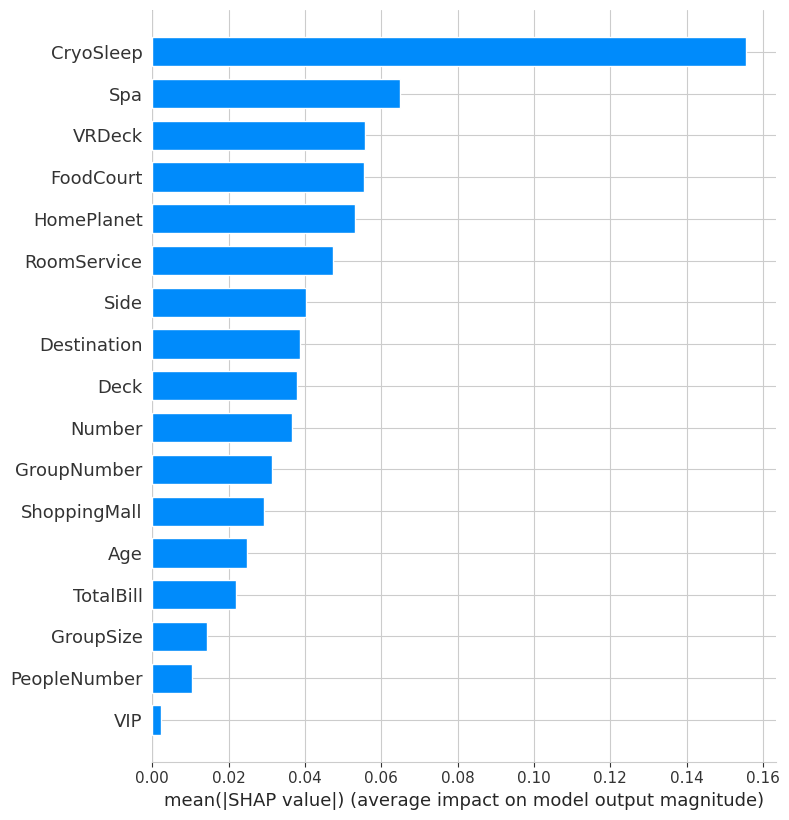

In [64]:
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_val)

shap.summary_plot(shap_values, X_val, plot_type='bar', feature_names=columns)

In conclusion, it can be assumed that CatBoostClassifier can achieve the highest accuracy on the test data - 80.173%. Also, in future works you can give special attention to features `TotalBill` (sum of `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa` and `VRDeck`), `CryoSleep`, `Deck` and `HomePlanet`.

## References

1. Chollet, F., & others. (2015). Keras. https://keras.io
2. Dorogush, A. V., Ershov, V., & Gulin, A. (2018). CatBoost: Gradient boosting with categorical features support. arXiv. https://arxiv.org/abs/1810.11363
3. Gupta, R. (2022). EDA using seaborn: Missing value & feature selection. Kaggle. https://www.kaggle.com/code/ritzig/eda-using-seaborn-missing-value-feature-selection#Missing-Value-Handling
4. Gusthema, elliot robot. (2023). Spaceship Titanic with TFDF. Kaggle. https://www.kaggle.com/code/gusthema/spaceship-titanic-with-tfdf
5. Guillame-Bert, M., Bruch, S., Stotz, R., & Pfeifer, J. (2023). Yggdrasil Decision Forests: A fast and extensible decision forests library. Proceedings of the 29th ACM SIGKDD Conference on Knowledge Discovery and Data Mining, 4068–4077. https://doi.org/10.1145/3580305.3599933
6. Lundberg, S. M., & Lee, S.-I. (2017). A unified approach to interpreting model predictions. In I. Guyon, U. V. Luxburg, S. Bengio, H. Wallach, R. Fergus, S. Vishwanathan, & R. Garnett (Eds.), Advances in Neural Information Processing Systems 30 (pp. 4765–4774). Curran Associates, Inc. http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions.pdf
7. O’Malley, T., Bursztein, E., Long, J., Chollet, F., Jin, H., Invernizzi, L., & others. (2019). KerasTuner. https://github.com/keras-team/keras-tuner

In [68]:
!git config --global user.name "serjshul"
!git config --global user.email "shulginsergey0@gmail.com"

In [74]:
!git reset --hard HEAD~1

HEAD is now at 4b4f77d Adding the data


In [75]:
!cp "/content/drive/MyDrive/kaggle/spaceship_titanic/spaceship_titanic.ipynb" "/content/Spaceship-Titanic"

%cd /content/Spaceship-Titanic
!rm -r /content/Spaceship-Titanic/catboost_info

!git add .
!git commit -m "References edition"
!git push origin main

/content/Spaceship-Titanic
[main dce7c58] References edition
 5 files changed, 1 insertion(+), 757 deletions(-)
 delete mode 100644 catboost_info/catboost_training.json
 delete mode 100644 catboost_info/learn/events.out.tfevents
 delete mode 100644 catboost_info/learn_error.tsv
 delete mode 100644 catboost_info/time_left.tsv
 rewrite spaceship_titanic.ipynb (77%)
Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 2 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 98.05 KiB | 1.14 MiB/s, done.
Total 3 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/serjshul/Spaceship-Titanic.git
   4b4f77d..dce7c58  main -> main
